## 0.0 Imports

In [50]:
import warnings
import re 
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from plotly              import express       as px
from sklearn             import cluster       as c 
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp
from sklearn.metrics     import silhouette_score 
from matplotlib          import pyplot        as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.1 Helper Functions

### 0.2 Load Dataset

In [51]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding='ISO-8859-1')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1)

In [52]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.0 Descrição dos Dados

In [53]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [54]:
df1.columns


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [55]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

### 1.2 Data dimension

In [56]:
print( 'Number of rows: {}'.format( df1.shape[0]))
print( 'Number of cols: {}'.format( df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [57]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4 Check NA

In [58]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [59]:
# remove NA
df1 = df1.dropna( subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0] / df_raw.shape[0])))

Removed data: 0.25


In [60]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.6 Change dtypes

In [61]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [62]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.7 Descriptive Statistics

In [63]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Atrributes

In [64]:
# central tendecy - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - desvio, padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T 

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m 

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


##### 1.7.1.1 Numerical Attributes - Investigating

1. Quantidade negativa(pode ser devolução)?
2. Preço unitário igual a zero (pode ser promoção)?

#### 1.7.2 Categorical Attributes

##### Invoice No

In [65]:
# problema: Temos invoice com letras e números
# df1['invoice_no'].astype(int)

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool(re.search( '[0-9]+', x))), :]

print( 'Total number of invoices: {}'.format(len(df_letter_invoices)))
print( 'Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']<0])))

Total number of invoices: 406829
Total number of negative quantity: 8905


##### Stock Code

In [66]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search('^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

##### Description

In [67]:
df1.head()

# Ação: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


##### Country

In [68]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [69]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: country, dtype: float64

In [70]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()


,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


## 2.0 Filtragem de Variavéis

In [71]:
df2 = df1.copy()
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [72]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [73]:
# Numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

## 3.0 Feature Engineering

In [78]:
df3 = df2.copy()

### 3.1 Feature Creation

In [79]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 
                    'invoice_date', 'unit_price', 'country'], 
                    axis=1).drop_duplicates(ignore_index=True)

In [80]:
# Gross Revenue (faturamento)
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_36460/2279638179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    27
dtype: int64

In [81]:
print(df2['invoice_date'].dtype)

datetime64[ns]


In [82]:
# Recency - Last day purchase
df_recency = df2_purchases.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [83]:
# Frequency
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [84]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [85]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.0,34.0,18.152222
1,13047,3232.59,56.0,9.0,18.904035
2,12583,6705.38,2.0,15.0,28.902500
3,13748,948.25,95.0,5.0,33.866071
4,15100,876.00,333.0,3.0,292.000000


## 4.0 EDA (Exploratory Data Analysis)

In [86]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

## 5.0 Data Preparation

In [87]:
df5 = df4.copy()

In [88]:
## Standard Scaler
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']])
df5['recency_days']  = ss.fit_transform( df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']])

In [89]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377179,2.791504,3.889207,-0.033935
1,13047,0.135378,-0.360996,0.620902,-0.033423
2,12583,0.524388,-0.899714,1.405296,-0.026618
3,13748,-0.120506,0.028079,0.097974,-0.023240
4,15100,-0.128600,2.402430,-0.163491,0.152447


## 6.0 Feature Selection

In [90]:
df6 = df5.copy()

## 7.0 Hyperparameter Fine-Tuning

In [91]:
X = df6.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.377179,2.791504,3.889207,-0.033935
1,0.135378,-0.360996,0.620902,-0.033423
2,0.524388,-0.899714,1.405296,-0.026618
3,-0.120506,0.028079,0.097974,-0.023240
4,-0.128600,2.402430,-0.163491,0.152447


In [92]:
clusters = [2, 3, 4, 5, 6, 7]

### 7.1 Within-Cluster Sum of Square (WSS)

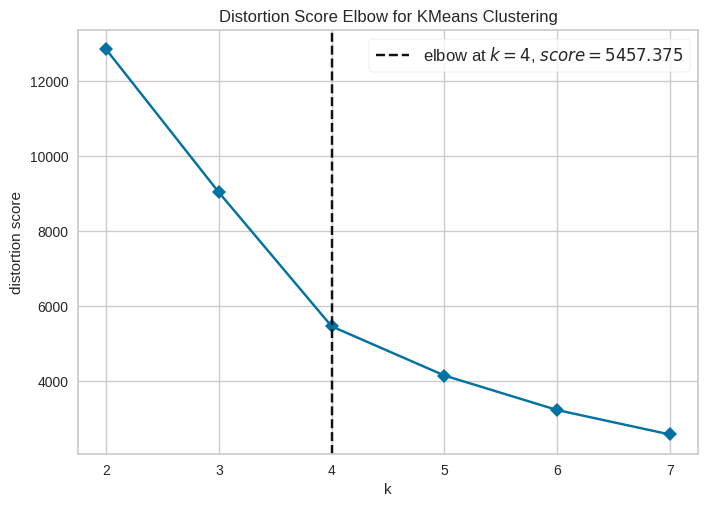

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

### 7.2 Silhouette Analysis

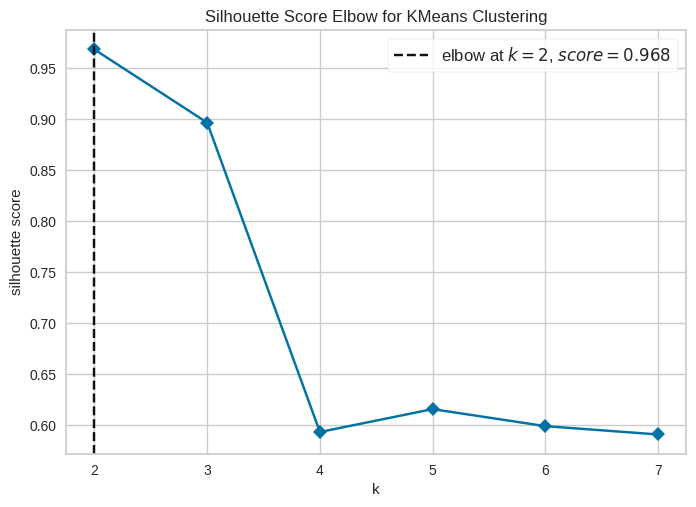

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [94]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

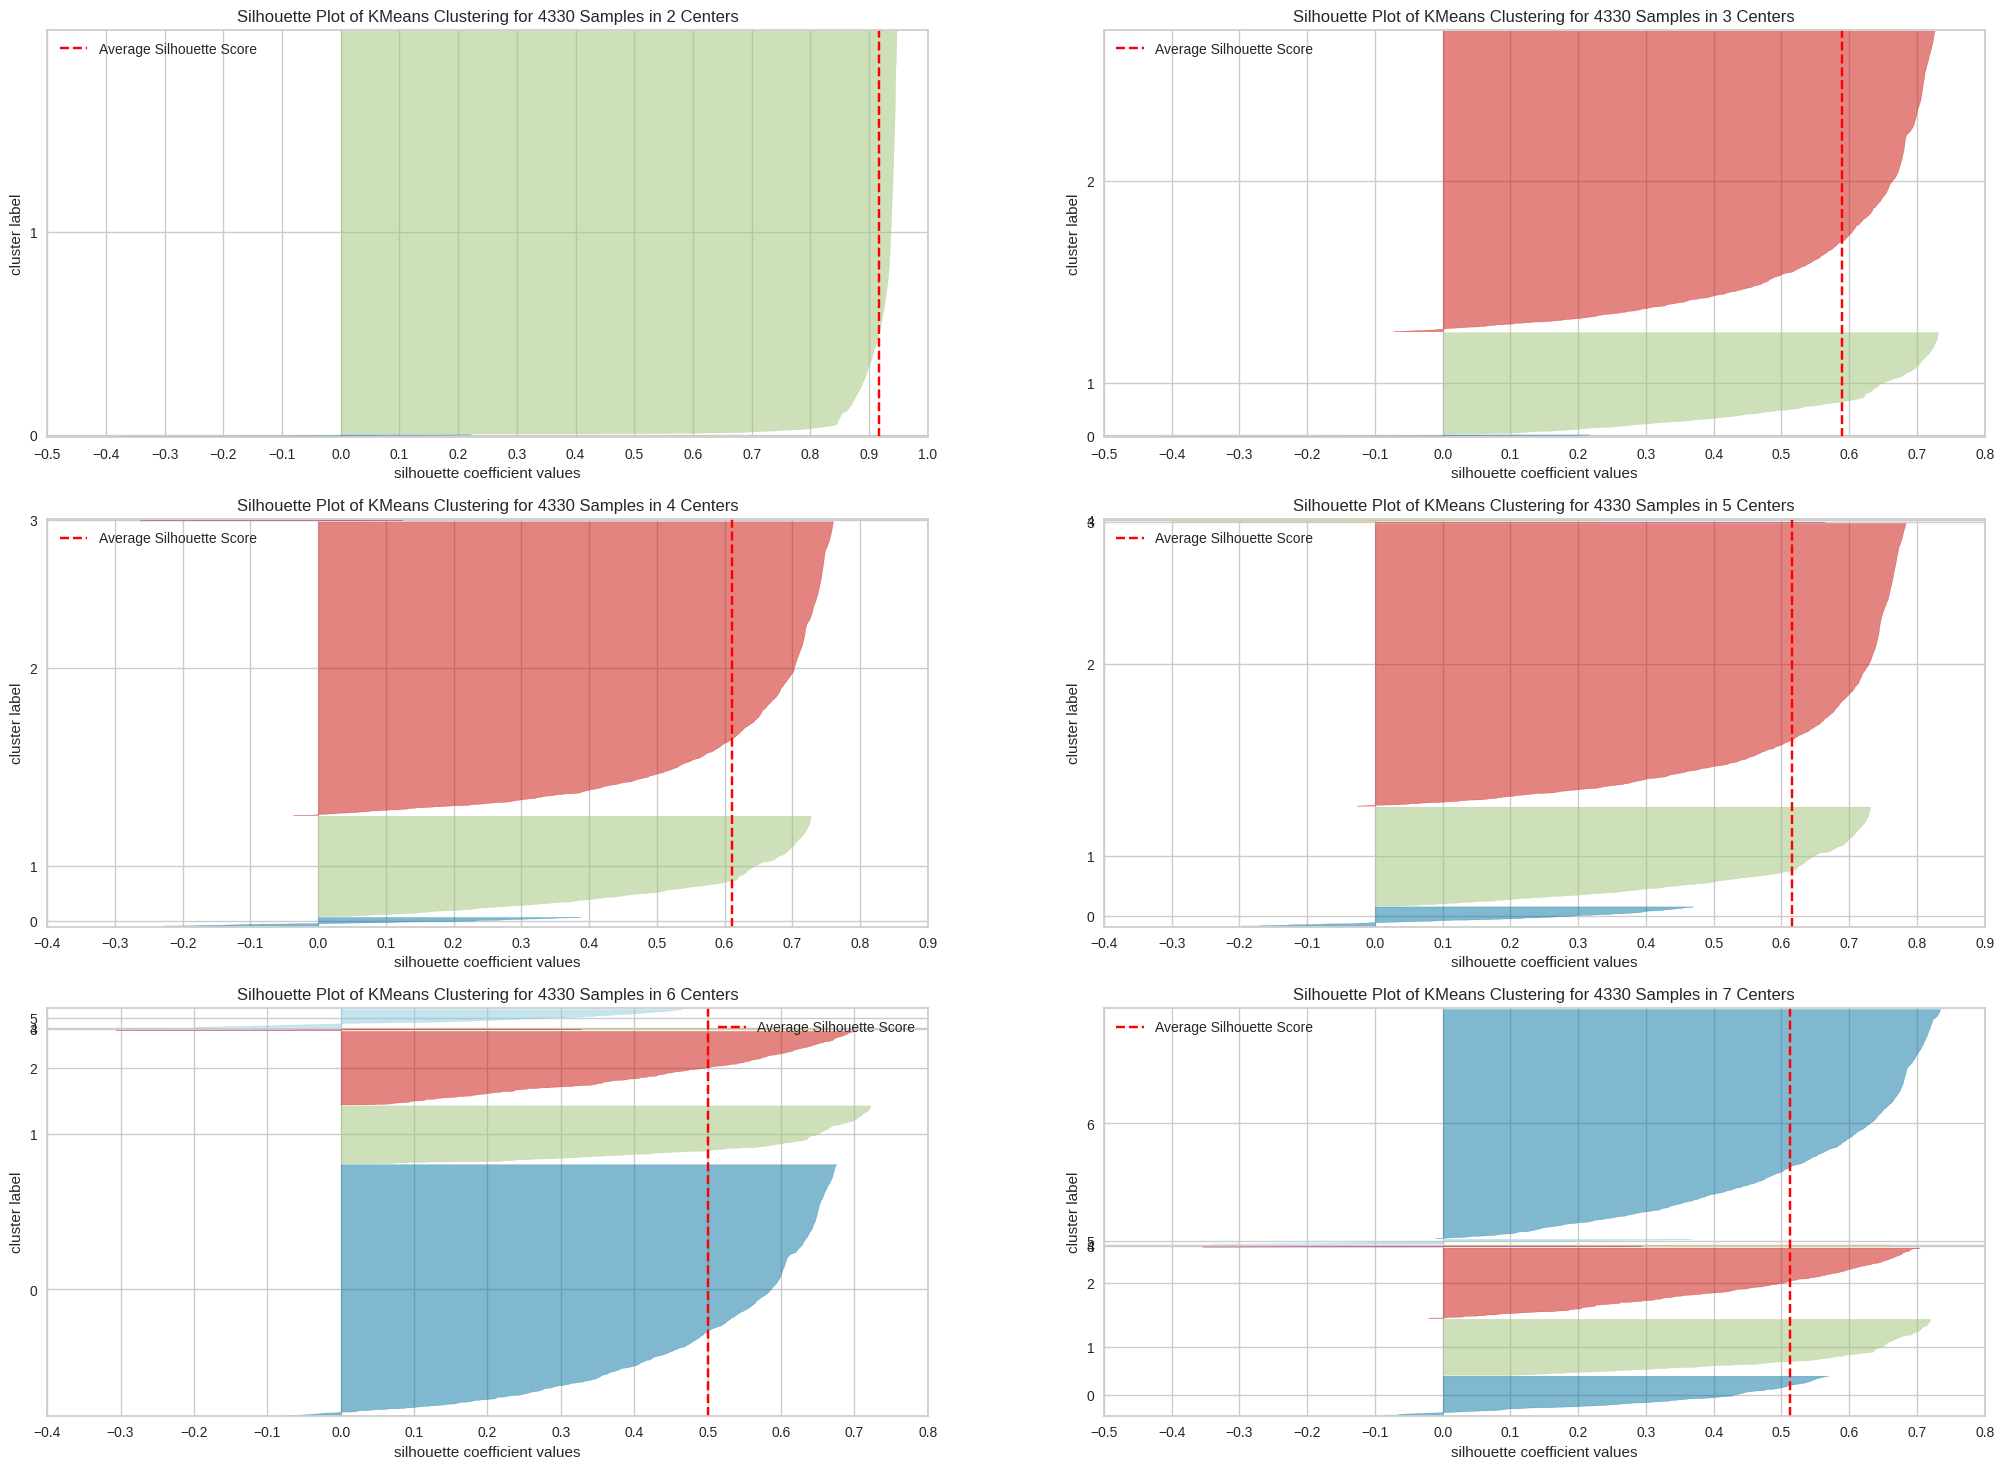

In [95]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k, 2)
    visualizer = SilhouetteVisualizer (km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

## 8.0  Model Training

### 8.1 K-Means

In [100]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [103]:
# WSS (Within-cluster Sum of Square)
print( 'WSS value: {}'.format(kmeans.inertia_))

X_array = X.values
## SS (Silhoutte Score)
print( 'SS value: {}'.format(silhouette_score(X_array, labels, metric='euclidean')))

WSS value: 9404.843680131593
SS value: 0.589281600325484


## 9.0 Cluster Analysis

In [104]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.791504,3.889207,-0.033935,0
1,13047,0.135378,-0.360996,0.620902,-0.033423,2
2,12583,0.524388,-0.899714,1.405296,-0.026618,2
3,13748,-0.120506,0.028079,0.097974,-0.023240,2
4,15100,-0.128600,2.402430,-0.163491,0.152447,0


### 9.1 Visualization Inspection

/home/marcelo/anaconda3/envs/env_base/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


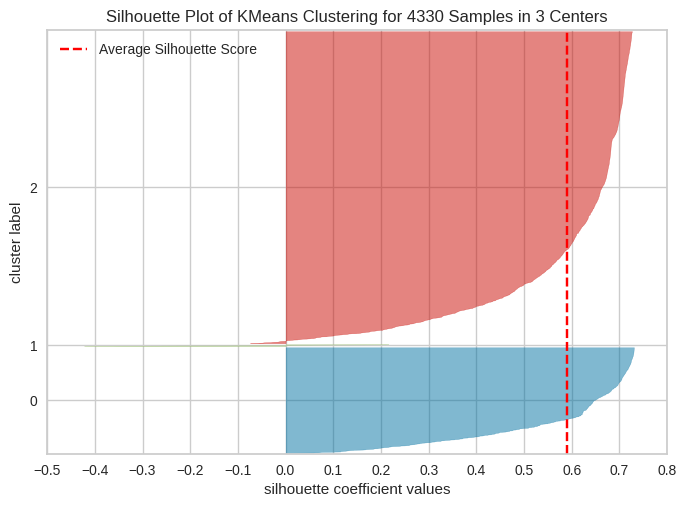

In [105]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 9.2 2d plot

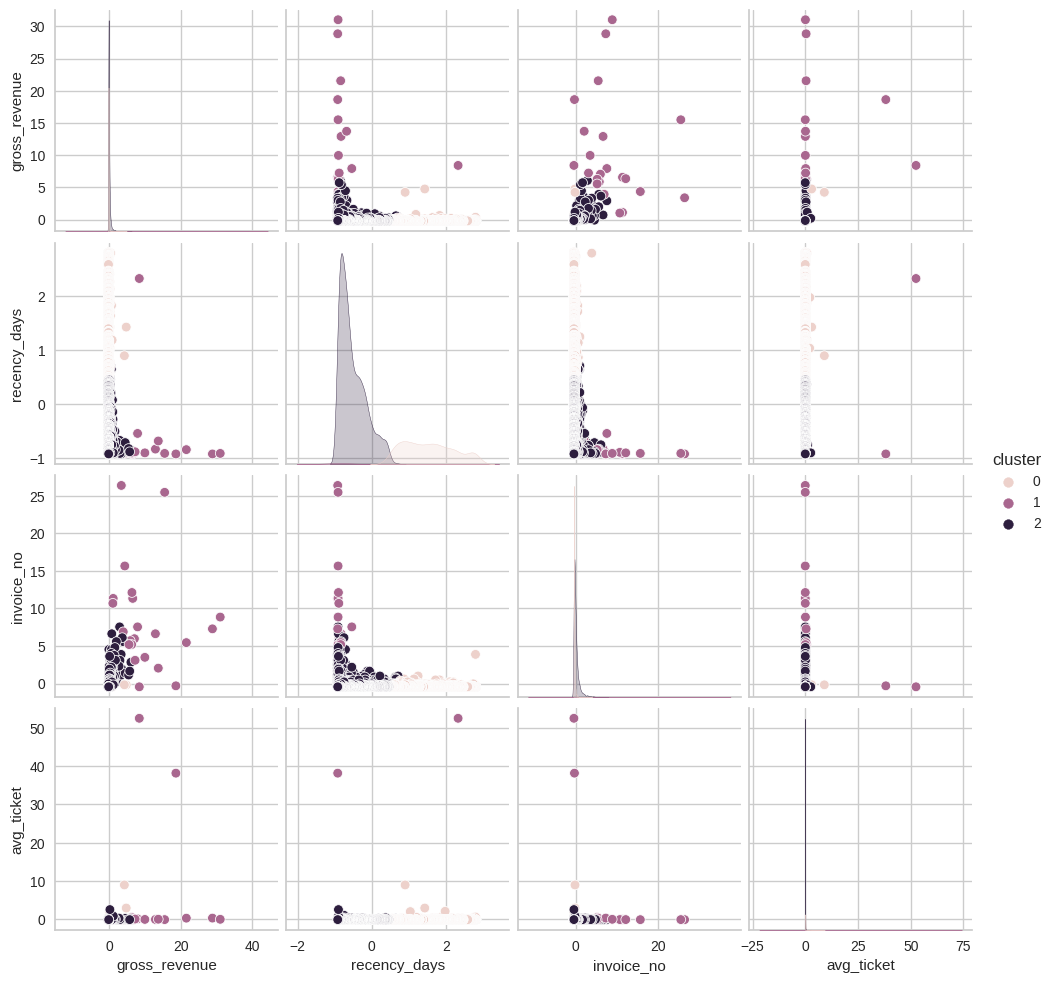

In [106]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

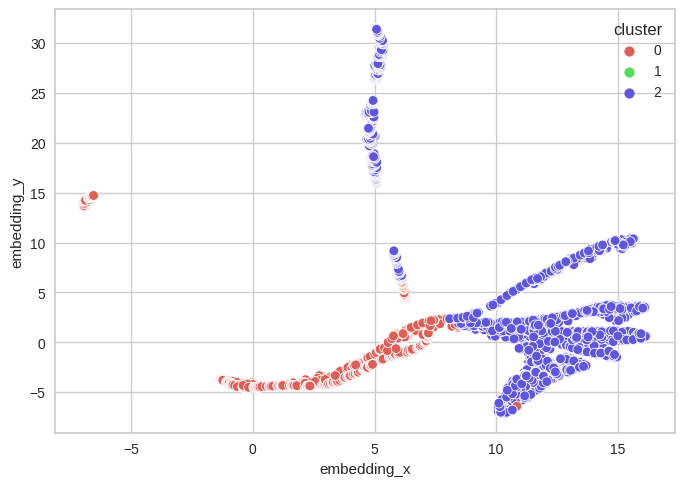

In [108]:
reducer = umap.UMAP( n_neighbors=90, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

### 9.4 Cluster Profile

In [109]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.377179,2.791504,3.889207,-0.033935,0
1,13047,0.135378,-0.360996,0.620902,-0.033423,2
2,12583,0.524388,-0.899714,1.405296,-0.026618,2
3,13748,-0.120506,0.028079,0.097974,-0.023240,2
4,15100,-0.128600,2.402430,-0.163491,0.152447,0


In [110]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_invoive_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoive_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,1089,25.150115,-0.164683,1.535951,-0.350525,-0.008756
1,1,22,0.508083,10.335282,-0.722409,8.441064,4.189464
2,2,3219,74.341801,-0.014923,-0.514681,0.060894,-0.025671


### Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (0.14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
    - Ticket méito: $253,00 dólares
        
### Cluster 02: 
    - Número de customers: 28 (0.64% do customers )
    - Recência em média: 6 dias
    - Compras em média: 57 compras
    - Receita em média: $42.614,00 dólares
    - Ticket médio: $162,00 dólares
        
### Cluster 03: 
    - Número de customers: 267 (6,10% do customers )
    - Recência em média: 20 dias
    - Compras em média: 19 compras
    - Receita em média: $8.089,00 dólares
    - Ticket médio: $62,78 dólares

### Cluster 04: 
    - Número de customers: 4.071 (93,10% do customers )
    - Recência em média: 96 dias
    - Compras em média: 3 compras
    - Receita em média: $946,00 dólares
    - Ticket médio: $25,00 dólares

## 10.0 Deploy to Production